In [1]:
import glob
import random
from typing import Callable, Optional, List

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
from matplotlib import pyplot as plt
from scipy.spatial import distance as distance_calculator
import torch
from torch import Tensor
from torch_geometric import nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.utils import scatter
import seaborn as sn
from torch.nn import Sequential as Seq, Linear as Lin, Dropout, ReLU, BatchNorm1d as BN
from torch_geometric.nn.conv import MessagePassing
from torch_multi_head_attention import MultiHeadAttention
import time

#### Loading the data
In each files, the frame numbers are shifted to come after the largest frame number in the previous file. This way all frame numbers are unique.

The dataset contains frames of 1 to 5 people.


In [2]:
random.seed(42)
column_names=['range','azimuth','doppler','snr','y','x','current_frame','seq']

features1: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/1/1/*.csv")])
features1.insert(8, "Label", np.zeros(len(features1), dtype=int), True)
max_frame = max(features1["current_frame"])

features2: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/2/2/*.csv")])
features2.insert(8, "Label", np.full(len(features2), 1, dtype=int), True)
min_frame = min(features2["current_frame"])
shift = max_frame-min_frame+10
features2["current_frame"] += shift
max_frame = max(features2["current_frame"])

features3: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/3/3/*.csv")])
features3.insert(8, "Label", np.full(len(features3), 2, dtype=int), True)
min_frame = min(features3["current_frame"])
shift = max_frame-min_frame+10
features3["current_frame"] += shift
max_frame = max(features3["current_frame"])

features4: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/4/4/*.csv")])
features4.insert(8, "Label", np.full(len(features4), 3, dtype=int), True)
min_frame = min(features4["current_frame"])
shift = max_frame-min_frame+10
features4["current_frame"] += shift
max_frame = max(features4["current_frame"])

features5: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/bigger/bigger/*.csv")])
features5.insert(8, "Label", np.full(len(features5), 4, dtype=int), True)
min_frame = min(features5["current_frame"])
shift = max_frame-min_frame+10
features5["current_frame"] += shift
max_frame = max(features5["current_frame"])

all_data = pd.concat([features1, features2, features3, features4, features5])
all_data.drop_duplicates(subset=['range','azimuth','doppler','snr','y','x','current_frame','Label'], inplace=True, ignore_index=True)
print("Number of data points: "+str(len(all_data)))

# group the data by frame numbers
all_data_grouped = all_data.groupby("current_frame")
print("Largest frame number: "+str(max_frame))
print("Total number of frames: "+str(len(all_data_grouped)))

Number of data points: 1242039
Largest frame number: 86242321.0
Total number of frames: 22126


In [3]:
def split_with_chunks(data_array, labels, num_chunks, val_frac, test_frac):
    train_frac = 1 - val_frac - test_frac
    train = []
    test = []
    val =[]
    label_values = np.array([data.iloc[0,5] for data in data_array])

    for label in labels:
        itemindex = np.where(label_values == label)
        frames = [data_array[i] for i in itemindex[0]]
        chunk_size = int(len(frames) / num_chunks)
        chunk_indexes = [i*chunk_size for i in range(num_chunks)]
        chunk_indexes.append(len(frames))
        for chunk in range(num_chunks):
            data_chunk = frames[chunk_indexes[chunk] : chunk_indexes[chunk+1]]
            train.extend(data_chunk[:int(train_frac * len(data_chunk))])
            val.extend(data_chunk[int(train_frac * len(data_chunk)):int((train_frac + val_frac) * len(data_chunk))])
            test.extend(data_chunk[int((train_frac + val_frac) * len(data_chunk)):])

    return train, val, test



#### Generate graphs

In [4]:
def min_max_normalization(frames:List[DataFrame],selected_cols):
    min_max = [(data[selected_cols].min(), data[selected_cols].max()) for data in frames]
    min_dict = min_max[0][0]
    max_dict = min_max[0][1]
    for mm in min_max[1:]:
        for key, value in mm[0].items():
            min_dict[key] = min(min_dict[key], value)
        for key, value in mm[1].items():
            max_dict[key] = max(max_dict[key], value)

    normalized_frames = [(frames[i][selected_cols]-min_dict)/(max_dict-min_dict) for i in range(len(frames))]
    normalized_frames = [pd.concat([normalized_frames[i], frame[['current_frame','Label']]], axis=1) for i, frame in enumerate(frames)]
    return normalized_frames

def connect_frames(current_frame, previous_frame, k: int, start_index: int):
    """
    Calculates the edges between two frames. 
    
    :param current_frame: The current frame containing parameters to calculate the distance based on 
    :param previous_frame: The previous frame containing parameters to calculate the distance based on 
    :param k: The number of nearest neighbours to have in the graph
    :param start_index: The index to start labeling the nodes from
    :return: The values (distance between points) of the edges and an adjacency list containing the nodes that are connected in the graph. 
            It also returns a boolean indicating whether the creation was successful or not.
    """
    edges = []
    adjacency_list = []
    previous_nodes = np.arange(len(previous_frame))
    for i, point in enumerate(current_frame):
        distances = distance_calculator.cdist([point], previous_frame, 'euclidean')[0]
        idx = distances.argsort()[::-1]
        distances = distances[idx]
        previous_nodes = previous_nodes[idx]
        if len(distances) < k:
            return [], [], False
        for j in range(k):
            edges.append(distances[j])
            adjacency_list.append((i+start_index, previous_nodes[j]+start_index+len(current_frame)))
    return edges, adjacency_list, True

def create_graph_list_with_overlap(frames:List[DataFrame], selected_cols, k = 3, frame_depth = 2):
    """
    Creates a list of Data objects that represents the graphs build from the input data. 
    The edges in the graph connects the frames to the previous frame by connecting each 
    points in a frame to it's nearest neighbour in the previous frame. 
    The nodes contain information about: doppler, snr, y and x. 
    The edges store information about the distance between the points (closer points have higher value).
    
    :param frames: input data grouped and sorted by the frame number
    :param k: the number of nearest neighbours to connect each points to
    :param frame_depth: the number of frames, one graph should contain
    :return: a list of Data objects, containing information about the created graphs
    """
    graphs = []
    for i, frame in enumerate(frames[frame_depth:]):
        nodes = []
        edges = []
        adjacency_list = []
        relevant_frames = frames[i: i + frame_depth + 1]
        point_data = [rf[selected_cols] for rf in relevant_frames]
        time_distance = relevant_frames[-1].iloc[0, 4] - relevant_frames[0].iloc[0, 4]
        if time_distance > frame_depth * 3 or relevant_frames[-1].iloc[0, 5] != relevant_frames[0].iloc[0, 5]:
            continue
        point_data_array = [df.to_numpy() for df in point_data]
        start_index = 0
        for depth in range(frame_depth):
            pairwise_edges, pairwise_adjacency_list, success = \
                connect_frames(point_data_array[frame_depth-depth][:,2:], point_data_array[frame_depth-depth-1][:,2:], k, start_index)
            if not success:
                break
            start_index += len(relevant_frames[frame_depth-depth])
            edges.extend(pairwise_edges)
            adjacency_list.extend(pairwise_adjacency_list)
            nodes.extend(point_data_array[frame_depth-depth])
        if not success:
                continue
        nodes.extend(point_data_array[0])
        label = frame["Label"].values[0]
        
        graphs.append(Data(x=torch.tensor(np.array(nodes), dtype=torch.float, device=device), 
                    edge_index=torch.tensor(np.array(adjacency_list), dtype=torch.int64, device=device).t().contiguous(),
                    edge_attr=torch.tensor(np.array(edges), dtype=torch.float, device=device),
                    y=torch.tensor(label, dtype=torch.int64, device=device)))
    return graphs

In [5]:
def load_graphs(train, val, test, frame_depths, ks, selected_cols):
    graph_sets = []
    for i, data_set in enumerate([train, val, test]):
        generated_graphs = []
        for f in frame_depths:
            for k in ks:
                try:
                    graphs = torch.load(f"data/frame_graphs_k{k}_frame_depth{f}_normalized_extended_chunk{num_chunks}_type{i}.pt")
                    print("File read")
                except Exception as e:
                    graphs = create_graph_list_with_overlap(data_set, selected_cols, k=k, frame_depth=f)
                    torch.save(graphs, f"data/frame_graphs_k{k}_frame_depth{f}_normalized_extended_chunk{num_chunks}_type{i}.pt")
                
                print(f"Number of graphs generated with k = {k} and frame depth = {f} for type {i}: {len(graphs)}")
                generated_graphs.append(graphs)
        graph_sets.append(generated_graphs)
    
    return graph_sets[0], graph_sets[1], graph_sets[2]

#### Hyperparameters

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
selected_cols = ['doppler','snr','y','x']
SHAPE_NAMES = [0,1,2,3,4]
frame_depths = [7] 
ks = [4]
num_chunks = 16
lr = 0.001

#### Loading or generating the graphs if not saved yet

In [7]:
data_array = np.asarray([frame for (_, frame) in all_data_grouped], dtype="object")
sorted_data = sorted(data_array,key=lambda x:x["current_frame"].max(axis=0))
norm_frames = min_max_normalization(sorted_data, selected_cols)

In [8]:
train, val, test = split_with_chunks(norm_frames, SHAPE_NAMES, num_chunks, 0.15, 0.15)
train_graps, val_graphs, test_graphs = load_graphs(train, val, test, frame_depths, ks, selected_cols)

train_dataloaders = []
test_dataloaders = []
val_dataloaders = []

for i in range(len(train_graps)):
    train_dataloaders.append(DataLoader(train_graps[i], batch_size=32, shuffle=True, num_workers = 0))
    test_dataloaders.append(DataLoader(test_graphs[i], batch_size=32, shuffle=True, num_workers = 0))
    val_dataloaders.append(DataLoader(val_graphs[i], batch_size=32, shuffle=True, num_workers = 0))


Number of graphs generated with k = 4 and frame depth = 7 for type 0: 7962
Number of graphs generated with k = 4 and frame depth = 7 for type 1: 1556
Number of graphs generated with k = 4 and frame depth = 7 for type 2: 1521


#### Split the dataset

#### Graph Neural Network

In [9]:
def MLP(channels):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])

def reset(nn):
    def _reset(item):
        if hasattr(item, 'reset_parameters'):
            item.reset_parameters()

    if nn is not None:
        if hasattr(nn, 'children') and len(list(nn.children())) > 0:
            for item in nn.children():
                _reset(item)
        else:
            _reset(nn)
            
class GeneralizedTemporalSelfAttentionDynamicEdgeConv(MessagePassing):
    def __init__(self, nn: Callable, 
                 attention_in_features: int,
                 k: int,
                 aggr: str = 'mean',
                 **kwargs):
        
        super(GeneralizedTemporalSelfAttentionDynamicEdgeConv,
              self).__init__(aggr=aggr, flow='source_to_target', **kwargs)

        self.nn = nn
        self.multihead_attn = MultiHeadAttention(attention_in_features, 8)
        self.k = k
        self.reset_parameters()

    def reset_parameters(self):
        reset(self.multihead_attn)
        reset(self.nn)

    def forward(self, x, data) -> Tensor:
        return self.propagate(data.edge_index, x=x, edge_attr=data.edge_attr, size=None, batch=data.batch)

    def message(self, x_i: Tensor, x_j: Tensor, edge_attr) -> Tensor:
        msg = torch.cat([x_j, x_i - x_j, torch.reshape(edge_attr, (len(edge_attr),1))], dim=-1)
        return self.nn(msg)

    def aggregate(self, inputs: Tensor, index: Tensor,
                  dim_size: Optional[int] = None) -> Tensor:
        original_shape = inputs.shape
        attention_input_shape = list([int(original_shape[0] / self.k)]) + list(original_shape)
        attention_input_shape[1] = self.k
        self_attention_input = inputs.reshape(attention_input_shape)
        attn_output = self.multihead_attn(self_attention_input, self_attention_input, self_attention_input)
        attn_output = attn_output.reshape(original_shape)
        # Apply attention mechanism
        return scatter(attn_output, index, dim=self.node_dim, dim_size=dim_size,
                       reduce=self.aggr)


In [10]:
class Net(torch.nn.Module):
    def __init__(self, out_channels, graph_convolution_layers=2, k=3, aggr='mean'):
        super().__init__()
        self.graph_convolution_layers = graph_convolution_layers

        self.conv1 = GeneralizedTemporalSelfAttentionDynamicEdgeConv(nn=MLP([2*4 + 1 , 64, 64, 64]),
                                                                     attention_in_features=64, 
                                                                     k=k, 
                                                                     aggr=aggr)
        
        self.conv2 = GeneralizedTemporalSelfAttentionDynamicEdgeConv(nn=MLP([2 * 64 + 1, 128]),
                                                                     attention_in_features=128,
                                                                     k=k, 
                                                                     aggr=aggr)

        if graph_convolution_layers == 1:
            self.lin1 = MLP([64, 1024])
        elif graph_convolution_layers == 2:
            self.lin1 = MLP([128 + 64, 1024])

        self.mlp = Seq(
            MLP([1024, 512]), Dropout(0.5), MLP([512, 256]), Dropout(0.5),
            Lin(256, out_channels))

    def forward(self, data):
        if self.graph_convolution_layers == 1:
            x1 = self.conv1(data.x, data)
            out = self.lin1(x1)
        elif self.graph_convolution_layers == 2:
            x1 = self.conv1(data.x, data)
            x2 = self.conv2(x1, data)
            out = self.lin1(torch.cat([x1, x2], dim=1))
        
        out = scatter(src=out, index=data.batch, dim=0, reduce='mean')
        out = self.mlp(out)
        return F.log_softmax(out, dim=1)

trained: 0


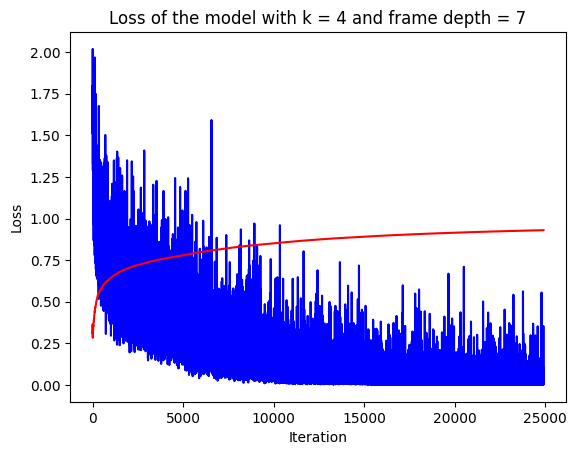

Training accuracy: 0.9301004772670184
Training loss: 0.0075155487
Accuracy of the model with k = 4 and frame depth = 7: 0.7712
--- 1262.7642962932587 seconds ---
evaluated: 0


In [11]:
model_losses = []
model_accuracies = []
models = []
val_accuracies = []
for i, train_dataloader in enumerate(train_dataloaders):
    start_time = time.time()
    k = ks[i % len(ks)]
    model = Net(5, graph_convolution_layers=1, k=k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    model.train()
    losses = []
    correct = 0
    count = 0
    accuracies = []
    for epoch in range(100):
        for train_batch in train_dataloader:
            train_batch = train_batch.to(device)
            optimizer.zero_grad()
            out = model(train_batch)
            pred = out.argmax(dim=1)
            correct += (pred == train_batch.y).sum()
            loss = F.nll_loss(out, train_batch.y)
            losses.append(loss.detach())
            loss.backward()
            optimizer.step()
            count += len(train_batch)
            acc = int(correct) / count
            accuracies.append(acc)
        scheduler.step()
    
    models.append(model)
    torch.save(model, f"data/trained_model_k{k}_frame_depth{frame_depths[int(i/len(ks))]}_normalized_extended_chunk{num_chunks}.pt")
    losses = [tensor.cpu().numpy() for tensor in losses]
    model_losses.append(losses)
    model_accuracies.append(accuracies)
    data = {'Loss': losses,
            'Accuracy': accuracies}
    df = pd.DataFrame(data)
    df.to_csv(f"data/training_loss_k{k}_frame_depth{frame_depths[int(i/len(ks))]}_normalized_extended_chunk{num_chunks}.csv", index=True)
    print(f"trained: {i}")

    plt.plot(losses, c="blue", label = "loss")
    plt.plot(accuracies, c="red", label = "accuracy")
    plt.title(f"Loss of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}")
    plt.ylabel("Loss")
    plt.xlabel("Iteration")
    plt.show()

    print("Training accuracy: "+str(accuracies[-1]))
    print("Training loss: "+str(losses[-1]))
    
    model.eval()
    total_y_pred_label = []
    total_y_true_label = []
    correct = 0
    for val_batch in val_dataloaders[i]:
        val_batch = val_batch.to(device)
        pred = model(val_batch).argmax(dim=1)
        
        total_y_pred_label.extend(pred)
        total_y_true_label.extend(val_batch.y)
        correct += (pred == val_batch.y).sum()
    acc = int(correct) / len(val_graphs[i])
    val_accuracies.append(acc)
    print(f'Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}: {acc:.4f}')
    print("--- %s seconds ---" % (time.time() - start_time))
    print(f"evaluated: {i}")

In [12]:
model.eval()
total_y_pred_label = []
total_y_true_label = []
correct = 0
for val_batch in test_dataloaders[i]:
    val_batch = val_batch.to(device)
    pred = model(val_batch).argmax(dim=1)
    
    total_y_pred_label.extend(pred)
    total_y_true_label.extend(val_batch.y)
    correct += (pred == val_batch.y).sum()
acc = int(correct) / len(test_graphs[i])
val_accuracies.append(acc)
print(f'Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}: {acc:.4f}')

Accuracy of the model with k = 4 and frame depth = 7: 0.7916


In [8]:
torch.cuda.empty_cache()

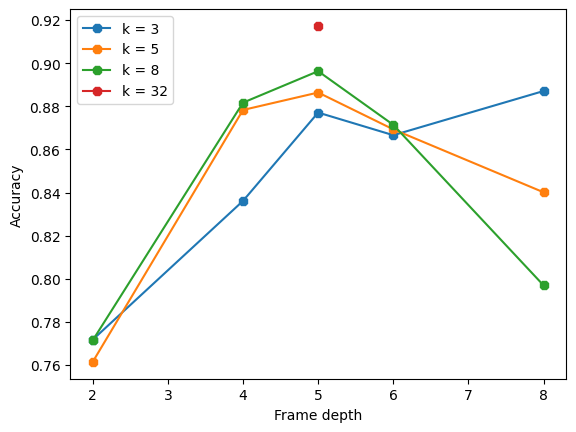

In [11]:
accuracies = np.array([0.7717, 0.7614, 0.7714,0.8361,0.8783,0.8817,0.8771,0.8864, 0.8963, 0.8666,0.8693,0.8714,0.8871,0.8401,0.7969])

frame_depths = [2,4,5,6,8]
ks =[3,5,8]
plt.plot(frame_depths, accuracies[[i*len(ks) for i in range(len(frame_depths))]], label = "k = 3", marker="8") 
plt.plot(frame_depths, accuracies[[i*len(ks)+1 for i in range(len(frame_depths))]], label = "k = 5", marker="8") 
plt.plot(frame_depths, accuracies[[i*len(ks)+2 for i in range(len(frame_depths))]], label = "k = 8", marker="8") 
plt.plot(5, 0.9173, label = "k = 32", marker="8") 
plt.xlabel("Frame depth")
plt.ylabel("Accuracy")
plt.legend() 
plt.show()

In [ ]:
for i, (loss, accuracy) in enumerate(zip(model_losses, model_accuracies)):
    plt.plot(loss, c="blue")
    plt.plot(accuracy, c="red")
    plt.title(f"Loss of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}")
    plt.ylabel("Loss")
    plt.xlabel("Iteration")
    plt.show()

    print("Accuracy: "+str(accuracy[-1]))
    print("Loss: "+str(loss[-1]))

In [ ]:
val_accuracies = []
for i, model in enumerate(models):
    model.eval()
    total_y_pred_label = []
    total_y_true_label = []
    correct = 0
    for val_batch in val_dataloaders[i]:
        val_batch = val_batch.to(device)
        pred = model(val_batch).argmax(dim=1)
        
        total_y_pred_label.extend(pred)
        total_y_true_label.extend(val_batch.y)
        correct += (pred == val_batch.y).sum()
    acc = int(correct) / len(val[i])
    val_accuracies.append(acc)
    print(f'Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}: {acc:.4f}')

In [10]:
best_model = torch.load("data/trained_model_k5_frame_depth5_normalized.pt")
best_model.eval()
total_y_pred_label = []
total_y_true_label = []
correct = 0
for val_batch in test_dataloaders[0]:
    val_batch = val_batch.to(device)
    pred = best_model(val_batch).argmax(dim=1)
    
    total_y_pred_label.extend(pred)
    total_y_true_label.extend(val_batch.y)
    correct += (pred == val_batch.y).sum()
acc = int(correct) / len(test[0])
print(f'Accuracy of the model with k = 5 and frame depth = 5: {acc:.4f}')

Accuracy of the model with k = 5 and frame depth = 5: 0.9436


In [10]:
best_model = models[0]
best_model.eval()
total_y_pred_label = []
total_y_true_label = []
correct = 0
for val_batch in test_dataloaders[0]:
    val_batch = val_batch.to(device)
    pred = best_model(val_batch).argmax(dim=1)
    
    total_y_pred_label.extend(pred)
    total_y_true_label.extend(val_batch.y)
    correct += (pred == val_batch.y).sum()
acc = int(correct) / len(test[0])
print(f'Accuracy of the model with k = {ks[i % len(ks)]} and frame depth = {frame_depths[int(i/len(ks))]}: {acc:.4f}')

Accuracy of the model with k = 8 and frame depth = 8: 0.9889


Text(0.5, 14.722222222222216, 'Predicated Label')

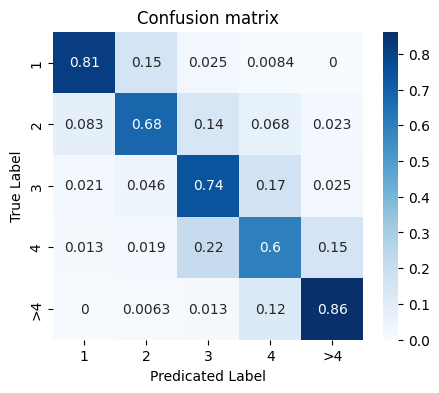

In [13]:
SHAPE_NAMES = [0,1,2,3,4]
SHAPE_LABELS = [1,2,3,4,">4"]
total_y_pred = [pred_label.item() for pred_label in total_y_pred_label]
total_y_true = [true_label.item() for true_label in total_y_true_label]
cm = confusion_matrix(total_y_true, total_y_pred, labels=SHAPE_NAMES)
# print(cm)
cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) 

df_cm = pd.DataFrame(cm, index = SHAPE_LABELS,
              columns = SHAPE_LABELS)
plt.figure(figsize = (5,4))
plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
figure = plot.get_figure()
plt.title("Confusion matrix")
plt.ylabel('True Label')
plt.xlabel('Predicated Label')

In [ ]:
torch.save(model, "data/trained_model_k3_tesla_no_feature_num_xy_dist_with_distance.pt")

In [ ]:
loaded_model = torch.load("data/trained_model_k3_tesla.pt")

In [ ]:
model.eval()
val_y_pred_label = []
val_y_true_label = []
correct = 0
for val_batch in val_dataloader:
    val_batch = val_batch.to(device)
    pred = model(val_batch).argmax(dim=1)
    val_y_pred_label.extend(pred)
    val_y_true_label.extend(val_batch.y)
    correct += (pred == val_batch.y).sum()
acc = int(correct) / len(val)
print(f'Accuracy: {acc:.4f}')

In [ ]:
SHAPE_NAMES = [1,2,3,4,5]
SHAPE_LABELS = [1,2,3,4,">4"]
total_y_pred = [pred_label.item() for pred_label in val_y_pred_label]
total_y_true = [true_label.item() for true_label in val_y_true_label]
cm = confusion_matrix(total_y_true, total_y_pred, labels=SHAPE_NAMES)
# print(cm)
cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) 

df_cm = pd.DataFrame(cm, index = SHAPE_LABELS,
              columns = SHAPE_LABELS)
plt.figure(figsize = (5,4))
plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
figure = plot.get_figure()
# plt.title("Confusion matrix")
plt.ylabel('True Label')
plt.xlabel('Predicated Label')

In [ ]:
data_points = np.array([d.y.item() for d in train_frame_graphs])
zeros = len(np.where(data_points  == 0)[0])
ones = len(np.where(data_points  == 1)[0])
twos = len(np.where(data_points  == 2)[0])
threes = len(np.where(data_points  == 3)[0]) 
fours = len(np.where(data_points  == 4)[0])
fives = len(np.where(data_points  == 5)[0])

labels = [0, 1,2,3,4,5]
sample_num = [zeros, ones, twos, threes, fours, fives]
p = plt.bar(labels, sample_num)
plt.xlabel("Number of people")
plt.ylabel("Number of samples")
plt.bar_label(p)
plt.show()

In [ ]:
data_points = np.array([d.y.item() for d in test_frame_graphs])
zeros = len(np.where(data_points  == 0)[0])
ones = len(np.where(data_points  == 1)[0])
twos = len(np.where(data_points  == 2)[0])
threes = len(np.where(data_points  == 3)[0]) 
fours = len(np.where(data_points  == 4)[0])
fives = len(np.where(data_points  == 5)[0])

labels = [0, 1,2,3,4,5]
sample_num = [zeros, ones, twos, threes, fours, fives]
p = plt.bar(labels, sample_num)
plt.xlabel("Number of people")
plt.ylabel("Number of samples")
plt.bar_label(p)
plt.show()